In [1]:
sys.path.append('/Users/jacoblourie')

In [2]:
import tensorflow as tf
import sys
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
#From my own library
from computer_vision.my_lib.blur_contrast import display_image
import pandas as pd

## Trying to build a full 3 layer neural net from scratch using MNIST data

In [144]:
#Load the dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train, x_test, y_test = x_train.astype('int'), y_train.astype('int'), x_test.astype('int'), y_test.astype('int')

#need to make it smaller though
# x_train = x_train[0:10000]
# y_train = y_train[0:10000]

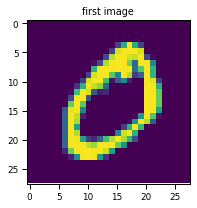

In [143]:
#see what an image looks like
display_image(x_train[1],'first image', size=(3,3))

## To make this simple, we will start by runnin a "is it a 1? " model 
We want to run a 1/0 model, so let's label all "1"s as 1, and everything else as 0

In [5]:
binary_y_train = np.array([1 if y == 1 else 0 for y in y_train])
binary_y_test = np.array([1 if y == 1 else 0 for y in y_test])

Let's go for 2 hidden layers, of 50 and 50 levels and let's just use sigmoid functions for now

In [6]:
#this helps much simpler
def flatten_and_reshape(x_train,x_test, y_train, y_test):

    x_train_flat = x_train.reshape((x_train.shape[0],-1)).T / 255
    x_test_flat = x_test.reshape((x_test.shape[0],-1)).T / 255
    print(x_train_flat.shape)
    bin_y_train = y_train.reshape(1,-1)
    bin_y_test = y_test.reshape(1,-1)
    return x_train_flat, x_test_flat, bin_y_train, bin_y_test

x_train_flat, x_test_flat, bin_y_train, bin_y_test = flatten_and_reshape(x_train, x_test, binary_y_train, binary_y_test)

#Create the binary model

# y_train_transp = y_train.reshape(1,-1) 
# y_test_transp = y_test.reshape(1,-1)



(784, 60000)


We'll go with a Gaussian initialisation of matrices

In [7]:
#Let's create the 'weights' matrices
def init_weights(x_train_flat, layer_1, layer_2,output):
    np.random_state = 112
    layer_1 = layer_1
    layer_2 = layer_2
    size_of_layer = [x_train_flat.shape[0], layer_1,layer_2, output]
    dict_of_weights = {}

    for layer in range(len(size_of_layer) - 1):
        dict_of_weights[f"W{layer+1}"] = np.random.randn(size_of_layer[layer+1],size_of_layer[layer])
        dict_of_weights[f"B{layer+1}"] = np.random.randn(size_of_layer[layer+1],1)
    #Print the sizes of the matrix
    print(f"Weights matrices")
    for name, matrix in dict_of_weights.items():
        print(name, matrix.shape)
    return dict_of_weights

dict_of_weights = init_weights(x_train_flat, 50, 15, 1)

Weights matrices
W1 (50, 784)
B1 (50, 1)
W2 (15, 50)
B2 (15, 1)
W3 (1, 15)
B3 (1, 1)


## To start with, let's do sigmoid activation for each layer

In [8]:
def sigmoid(x):
    return (1/(1+np.exp(-x)))

dict_of_FP_values = {}
#FORWARD PROPOGATION
def sigmoid_forward_prop(previous_a, W, B):
    Z = W @ previous_a + B
    next_A = sigmoid(Z)
    return Z, next_A

def forward_prop(dict_of_weights,x_train_flat,bin_y_train):
    W1, B1, W2, B2, W3, B3 = dict_of_weights.values()
    
    Z1, A1 = sigmoid_forward_prop(x_train_flat, W1, B1)
    Z2, A2 = sigmoid_forward_prop(A1, W2, B2)    
    Z3, A3 = sigmoid_forward_prop(A2, W3, B3)
    
    dict_of_FP_values['Z1'] = Z1
    dict_of_FP_values['A1'] = A1
    dict_of_FP_values['Z2'] = Z2
    dict_of_FP_values['A2'] = A2
    dict_of_FP_values['Z3'] = Z3
    dict_of_FP_values['A3'] = A3
    
    Cost = ((bin_y_train - A3) @ np.transpose(bin_y_train - A3) / A3.size )[0]

    return dict_of_FP_values, Cost

dict_of_FP_values, Cost = forward_prop(dict_of_weights,x_train_flat,bin_y_train)

## Great, so now we need to do back propogation.



Worth nothing, that everything is positive - this kind of makes sense because right now the dumb model can be improved by just setting everything to 0 (as only 10% of outputs are "1")

Let's keep going back through the differentials

In [9]:
def back_prop_one_layer_from_A_to_previous_A(cost_of_that_A, Z, prev_A,W):    
        #going back from A to z
        dAn_dZn = np.exp(-Z) / ((1+np.exp(-Z))**2)
        dC_dZn = cost_of_that_A * dAn_dZn
        
        #get diffs at that layer
        dZn_dWn = prev_A
        dZn_dBn = np.zeros_like(Z) + 1

        #combien to get useful differentials
        dC_dWn = dC_dZn @ dZn_dWn.T / Z.size
        dC_dBn = np.sum(dC_dZn @ dZn_dBn.T,axis=1,keepdims=True) / dZn_dBn.shape[1]

        #and then get the previous layer cost fuctions
        dZn_dA_minus_one = W
        dC_dA_minus_one = (dC_dZn.T @ dZn_dA_minus_one).T

        return dC_dWn, dC_dBn, dC_dZn, dC_dA_minus_one

def back_prop(dict_of_weights, dict_of_FP_values, bin_y_train, x_train_flat):
    W1, B1, W2, B2, W3, W3 = dict_of_weights.values()
    Z1, A1, Z2, A2, Z3, A3 = dict_of_FP_values.values()
    
    differentiat_dict = {}
    
    '''Let's look at W3 and B3 first'''
    
    #This line is unique
    dC_dA3 = 2*(A3 - bin_y_train) #gives 1 by m matrix

    #do the back props
    dC_dW3, dC_dB3, dC_dZ3, dC_dA2 = back_prop_one_layer_from_A_to_previous_A(dC_dA3, Z3, A2, W3)
    dC_dW2, dC_dB2, dC_dZ2, dC_dA1 = back_prop_one_layer_from_A_to_previous_A(dC_dA2, Z2, A1, W2)
    dC_dW1, dC_dB1, dC_dZ1, dC_dA0 = back_prop_one_layer_from_A_to_previous_A(dC_dA1, Z1, x_train_flat, W1)

    differentiat_dict['dW1'] = dC_dW1
    differentiat_dict['dB1'] = dC_dB1
    differentiat_dict['dW2'] = dC_dW2
    differentiat_dict['dB2'] = dC_dB2
    differentiat_dict['dW3'] = dC_dW3
    differentiat_dict['dB3'] = dC_dB3

    return differentiat_dict

differentiat_dict = back_prop(dict_of_weights, dict_of_FP_values, bin_y_train, x_train_flat)

In [10]:
dict_of_FP_values['Z3'].size

60000

## Great stuff, now we need to update the weights.

In [11]:
def gradient_descent(learning_rate, dict_of_weights, differentiat_dict):
    
    #we have dictionaries for the weights and the differentials, which we should be able to use quite easily here. They are also in order so we can kind of cheat... but let's not 
    for key, value in dict_of_weights.items():
        dict_of_weights[key] += -learning_rate * differentiat_dict[f'd{key}']
    

## SO, now let's run this in a loop and see what happens to Cost

In [12]:
#We start with forward propogation, storing the cost
learning_rate = 0.1 #set an arbitrary learning rate... we can iterate and try a few others soon
iterations = 250
cost = []

for iteration in range(iterations):
    
    dict_of_FP_values, Cost = forward_prop(dict_of_weights,x_train_flat,bin_y_train)
    cost.append(Cost[0]) #add cost to the list.
    #then, do back prop, storing the differentials
    differentiat_dict = back_prop(dict_of_weights, dict_of_FP_values, bin_y_train, x_train_flat)

    #then, do the gradient descent. Nothing stored, the weights just update and we re-use the new values in forward prop.
    gradient_descent(learning_rate, dict_of_weights, differentiat_dict)
    if iteration % 100 == 0:
        print(f'iteration: {iteration}\ncost: {Cost}')

iteration: 0
cost: [0.34038404]
iteration: 100
cost: [0.11923292]
iteration: 200
cost: [0.11425228]


In [13]:
pd.Series(bin_y_train[0]).value_counts()

0    53258
1     6742
dtype: int64

In [14]:
pd.cut(pd.Series(dict_of_FP_values['A3'][0]), bins=10, right=False).value_counts()

[0.000551, 0.0682)    51771
[0.0682, 0.136)        5594
[0.136, 0.204)         1578
[0.204, 0.271)          546
[0.271, 0.339)          263
[0.339, 0.407)          129
[0.407, 0.474)           63
[0.474, 0.542)           26
[0.542, 0.61)            21
[0.61, 0.678)             9
dtype: int64

## OK. It just seems to have optimised by making everything 0. Let's see what happens if we just have two numbers in the sample

In [15]:

def reduced_form(y_train,y_test, x_train, x_test, numbers):
    
    print(numbers)
    #Put in an array format
    y_train_arr_format = np.array(y_train)
    y_test_arr_format = np.array(y_test)

    y_train_df = pd.DataFrame( {'value': y_train_arr_format})
    train_index = y_train_df['value'].isin(numbers)

    #Repeat this for test
    y_test_df = pd.DataFrame( {'value': y_test_arr_format})
    test_index = y_test_df['value'].isin(numbers)

    #then get the relevant lists
    y_train_reduced = y_train_arr_format[train_index]
    x_train_reduced = x_train[train_index]
    y_test_reduced = y_test_arr_format[test_index]
    x_test_reduced = x_test[test_index]

    #flatten the shapes - note, we're not using x_test just yet, so can leave this as is.
    x_train_subset, x_test_subset, y_train_subset, y_test_subset = flatten_and_reshape(x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced)
    
    return x_train_subset, x_test_subset, y_train_subset, y_test_subset

numbers_looked_at = [1,2,3,4]

x_train_binary, x_test_binary, y_train_binary, y_test_binary = reduced_form(y_train, y_test, x_train, x_test, [1,0])

[1, 0]
(784, 12665)


In [16]:
#shows the split of class values
pd.Series(y_train_binary[0]).value_counts()

1    6742
0    5923
dtype: int64

Let's run the iteration with this new set

In [17]:
##RUNNING AN ITERATION WITH 2 CLASSES

#init the weights
dict_of_weights_2 = init_weights(x_train_binary, 50, 50, 1)
#then let's do some iterations
learning_rate = 0.1 #set an arbitrary learning rate... we can iterate and try a few others soon
iterations = 1000
cost = []

for iteration in range(iterations):
    
    dict_of_FP_values_bin, Cost = forward_prop(dict_of_weights_2,x_train_binary,y_train_binary)
    cost.append(Cost[0]) #add cost to the list.
    #then, do back prop, storing the differentials
    differentiat_dict_bin = back_prop(dict_of_weights_2, dict_of_FP_values_bin, y_train_binary, x_train_binary)

    #then, do the gradient descent. Nothing stored, the weights just update and we re-use the new values in forward prop.
    gradient_descent(learning_rate, dict_of_weights_2, differentiat_dict_bin)
    


Weights matrices
W1 (50, 784)
B1 (50, 1)
W2 (50, 50)
B2 (50, 1)
W3 (1, 50)
B3 (1, 1)


In [18]:
pd.cut(pd.Series(dict_of_FP_values_bin['A3'][0]), bins=10, right=False).value_counts()

[0.000126, 0.0999)    4054
[0.898, 0.999)        3922
[0.799, 0.898)        1734
[0.0999, 0.2)          851
[0.699, 0.799)         644
[0.2, 0.3)             399
[0.599, 0.699)         332
[0.3, 0.399)           269
[0.499, 0.599)         246
[0.399, 0.499)         214
dtype: int64

## Great - we have values at both ends of the spectrum!

Let's see what happens to the cost function

/Users/jacoblourie/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

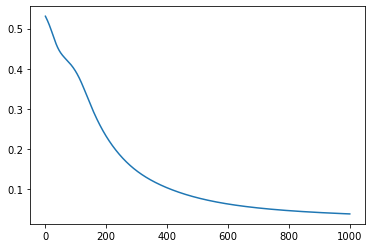

In [19]:
cost_x = np.linspace(1,iterations,iterations)
fig = plt.figure(figsize = (6,4))
sns.lineplot(cost_x,cost)

## Next - let's use this to "Predict the Test Set"

In [20]:
def predict(vector_of_x, vector_of_y):
    FP_values, Cost = forward_prop(dict_of_weights_2,vector_of_x, vector_of_y)
    y_prob = FP_values['A3']
    #y_pred = round(FP_values['A3'])
    accuracy_vector = abs(y_prob - vector_of_y) < 0.5
    return y_prob,  accuracy_vector

prob, av = predict(x_test_binary, y_test_binary)

In [21]:
pd.Series(av[0]).value_counts()

True     2025
False      90
dtype: int64

## Section 2 - Softmax!



In [22]:
#for y, we need to do some form of hot encoding.
from sklearn.preprocessing import OneHotEncoder

def create_one_hot_train_and_test(y_train, y_test):
    one_hot = OneHotEncoder(sparse = False)
    one_hot_y_train= one_hot.fit_transform(y_train.reshape(-1,1)).T ###currently doing it on two classes
    one_hot_y_test = one_hot.fit_transform(y_test.reshape(-1,1)).T
    return one_hot_y_train, one_hot_y_test
one_hot_y_train, one_hot_y_test = create_one_hot_train_and_test(y_train_binary, y_test_binary )

In [23]:
# let's see if we can initialise the weights
dict_of_weights_softmax = init_weights(x_train_binary, 50, 50, 2)

Weights matrices
W1 (50, 784)
B1 (50, 1)
W2 (50, 50)
B2 (50, 1)
W3 (2, 50)
B3 (2, 1)


## Gravy. Now let's take a look at the forward prop

One thing for sure is that we need to change the calculation of the cost function.

In [24]:
one_hot_y_train.shape

(2, 12665)

In [25]:
dict_of_FP_values_softmax = {}
#FORWARD PROPOGATION
def last_leg_softmax(previous_a, W, B):
    Z = W @ previous_a + B
    A = np.exp(Z)
    A = A / np.sum(A,axis=0) 
    return Z, A

def forward_prop_softmax(dict_of_weights,x_train,y_train_softmax):
    dict_of_FP_values = {}
    W1, B1, W2, B2, W3, B3 = dict_of_weights.values()
    Z1, A1 = sigmoid_forward_prop(x_train, W1, B1)
    Z2, A2 = sigmoid_forward_prop(A1, W2, B2)    
    Z3, A3 = last_leg_softmax(A2, W3, B3)
    
    dict_of_FP_values['Z1'] = Z1
    dict_of_FP_values['A1'] = A1
    dict_of_FP_values['Z2'] = Z2
    dict_of_FP_values['A2'] = A2
    dict_of_FP_values['Z3'] = Z3
    dict_of_FP_values['A3'] = A3
    
    #for cost fucntion, use the y log y_hat
    Cost = -np.sum(y_train_softmax * np.log(A3)) / y_train_softmax.shape[1]
    
    return dict_of_FP_values, Cost

dict_of_FP_values_softmax, Cost_softmax = forward_prop_softmax(dict_of_weights_softmax,x_train_binary,one_hot_y_train)

In [97]:
def back_prop_first_soft_max_layer(y_true, y_predicted, previous_A, Z, W):    
    #dC/dz first layer is just y - ÿ
    dC_dZ_final = y_predicted - y_true

    #get diffs at that layer
    dZfinal_dW = previous_A
    dZfinal_dB = np.zeros_like(Z) + 1

    #combine to get useful differentials
    dC_dW = dC_dZ_final @ dZfinal_dW.T / Z.size
    dC_dB = np.sum(dC_dZ_final @ dZfinal_dB.T,axis=1,keepdims=True) / dZfinal_dB.shape[1]

    #and then get the previous layer cost fuctions
    dZfinal_dA_minus_one = W
    dC_dA_minus_one = (dC_dZ_final.T @ dZfinal_dA_minus_one).T

    return dC_dW, dC_dB, dC_dA_minus_one

def back_prop_softmax(dict_of_weights_softmax, dict_of_FP_values_softmax, y_true, x_train_flat):
    W1, B1, W2, B2, W3, W3 = dict_of_weights_softmax.values()
    Z1, A1, Z2, A2, Z3, A3 = dict_of_FP_values_softmax.values()
    
    differentiat_dict = {}
    
    #This line is unique it's for the first layer
    dC_dW3, dC_dB3, dC_dA2 = back_prop_first_soft_max_layer(y_true, A3, A2, Z3, W3)

    #do the back props
    dC_dW2, dC_dB2, dC_dA1 = back_prop_one_layer_from_A_to_previous_A(dC_dA2, Z2, A1, W2)
    dC_dW1, dC_dB1, dC_dA0 = back_prop_one_layer_from_A_to_previous_A(dC_dA1, Z1, x_train_flat, W1)

    differentiat_dict['dW1'] = dC_dW1
    differentiat_dict['dB1'] = dC_dB1
    differentiat_dict['dW2'] = dC_dW2
    differentiat_dict['dB2'] = dC_dB2
    differentiat_dict['dW3'] = dC_dW3
    differentiat_dict['dB3'] = dC_dB3

    return differentiat_dict



In [95]:
##softmax iteration
learning_rate = 0.1 #set an arbitrary learning rate... we can iterate and try a few others soon
iterations_SM = 50
    

def soft_max_iteration(learning_rate, iterations, x_train, y_train):
    cost_softmax = []
    dict_of_weights_softmax = init_weights(x_train, 75, 40, y_train.shape[0])

    for iteration in range(iterations):

        dict_of_FP_values_softmax, Cost_softmax = forward_prop_softmax(dict_of_weights_softmax,x_train,y_train)
        cost_softmax.append(Cost_softmax) #add cost to the list.
        
        #then, do back prop, storing the differentials

        differentiat_dict_softmax = back_prop_softmax(dict_of_weights_softmax, dict_of_FP_values_softmax, y_train, x_train)
        #then, do the gradient descent. Nothing stored, the weights just update and we re-use the new values in forward prop.
        gradient_descent(learning_rate, dict_of_weights_softmax, differentiat_dict_softmax)
        
        # if iteration % 100 == 0:
        #     print(f'iteration: {iteration}\ncost: {Cost_softmax}')
    
    return cost_softmax, dict_of_FP_values_softmax, dict_of_weights_softmax



In [98]:
#running the function
cost_softmax_binary, dict_of_FP_values_softmax_binary, dict_of_weights_softmax_binary = soft_max_iteration(learning_rate, iterations_SM, x_train_binary, one_hot_y_train)


Weights matrices
W1 (75, 784)
B1 (75, 1)
W2 (40, 75)
B2 (40, 1)
W3 (2, 40)
B3 (2, 1)


In [99]:
def plot_cost_over_time(cost_list, iterations):
    sns.set_context('paper')
    fig = plt.figure(figsize=(8,4))
    ax = sns.lineplot(np.linspace(1,iterations,iterations),cost_list)
    ax.set_title('cost over time')
    ax.set_ylabel('Cost function')
    ax.set_xlabel('iteration')
    plt.show()

plot_cost_over_time(cost_softmax_binary, iterations)

/Users/jacoblourie/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: arrays must all be same length

In [ ]:
pd.DataFrame(dict_of_FP_values_softmax_binary['A3'])

Alright, does it predict things correctly?

In [101]:
def softmax_predictions(dict_of_FP_values_softmax, y_true, number_of_layers):
    predictions_softmax = dict_of_FP_values_softmax[f'A{number_of_layers}'].T
    list_of_predictions = []
    for row in predictions_softmax:
        max = np.amax(row)
        for idx,col in enumerate(row):
            if col == max:
                list_of_predictions.append(idx)
                break

    table_preds = pd.DataFrame({'predictions': list_of_predictions, 'actuals':y_true[0]})
    table_preds['Correct'] = table_preds['predictions'] - table_preds['actuals']
    table_preds['Correct'] = table_preds['Correct'].apply(lambda x: 1 if x == 0 else 0)
    print(f"Correct prediction score out of 1: {np.sum(table_preds['Correct'])/len(table_preds)}")


In [102]:
softmax_predictions(dict_of_FP_values_softmax, y_train_binary, 3)
test_dict_binary_SM, _ = forward_prop_softmax(dict_of_weights_softmax_binary,x_test_binary,y_test_binary)
softmax_predictions(test_dict_binary_SM, y_test_binary, 3)

Correct prediction score out of 1: 0.5238847216739044
Correct prediction score out of 1: 0.5465721040189125


## End of prediction section! 

Now trying with three classes


## Refactor for flexible structure

In [126]:
#WEIGHTS INITIALISATION

def init_weights_flexible(x_train_flat, array_of_layers,y_train, xavier = 'no'):
    np.random_state = 112
    size_of_layer = [x_train_flat.shape[0]] + array_of_layers + [y_train.shape[0]]
    dict_of_weights = {}

    for layer in range(len(size_of_layer) - 1):
        dict_of_weights[f"W{layer+1}"] = np.random.randn(size_of_layer[layer+1],size_of_layer[layer])
        dict_of_weights[f"B{layer+1}"] = np.random.randn(size_of_layer[layer+1],1)
        if xavier == 'yes':
            dict_of_weights[f"W{layer+1}"] * np.sqrt(6)/(np.sqrt(size_of_layer[layer+1]+size_of_layer[layer]))
            dict_of_weights[f"B{layer+1}"] * np.sqrt(6)/(np.sqrt(size_of_layer[layer+1]+1))
        #Print the sizes of the matrix
    print(f"Weights matrices")
    for name, matrix in dict_of_weights.items():
        print(name, matrix.shape)
    return dict_of_weights

layers_test = [100,100,50,50]
dict_of_weights_flex_test = init_weights_flexible(x_train_binary, layers_test, x_train_binary)

Weights matrices
W1 (100, 784)
B1 (100, 1)
W2 (100, 100)
B2 (100, 1)
W3 (50, 100)
B3 (50, 1)
W4 (50, 50)
B4 (50, 1)
W5 (784, 50)
B5 (784, 1)


In [149]:
##FORWARD PROPOGATION FLEXIBLE

def sigmoid(x):
    return (1/(1+np.exp(-x)))

#FORWARD PROPOGATION SIGMOID
def sigmoid_forward_prop(previous_a, W, B):
    Z = W @ previous_a + B
    next_A = sigmoid(Z)
    return Z, next_A


#Last leg forward prop
def last_leg_softmax(previous_a, W, B):
    Z = W @ previous_a + B
    A = np.exp(Z)
    A = A / np.sum(A,axis=0) 
    return Z, A

def forward_prop_softmax_flex(dict_of_weights,x_train,y_train_softmax):
    
    #Create blank dict_of_FP_values
    dict_of_FP_values = {}
    #This allows ut include x_train in the loop.
    dict_of_FP_values['A0'] = x_train

    #initially do fp on the xtrain
    layers = int(len(dict_of_weights.keys())/2)
    middle_layers = layers -2 #this is the number of weights than don't include the first and last layer

    for key in range(1,layers): #starts at 1, goes up to the last hidden layer
    
        dict_of_FP_values[f'Z{key}'], dict_of_FP_values[f'A{key}'] = sigmoid_forward_prop(dict_of_FP_values[f'A{key-1}'], dict_of_weights[f'W{key}'], dict_of_weights[f'B{key}'])

    #then do last leg which is a different function    
    dict_of_FP_values[f'Z{layers}'], dict_of_FP_values[f'A{layers}'] = last_leg_softmax(dict_of_FP_values[f'A{layers-1}'], dict_of_weights[f'W{layers}'], dict_of_weights[f'B{layers}']) 
    
    #for cost fucntion, use the y log y_hat
    Cost = -np.sum(y_train_softmax * np.log(dict_of_FP_values[f'A{layers}'])) / y_train_softmax.shape[1]
    
    return dict_of_FP_values, Cost

#dict_of_FP_values_softmax_test_flex_function, Cost_softmax_flex_function = forward_prop_softmax_flex(dict_of_weights_flex_test,x_train_all,all_y_train_one_hot)

In [106]:
## BACK PROPOGATION 
def back_prop_one_layer_from_A_to_previous_A(cost_of_that_A, Z, prev_A,W):    
    
    #Start with the cost of an Activated neuron
    dAn_dZn = np.exp(-Z) / ((1+np.exp(-Z))**2) #sigmoid differentiated
    dC_dZn = cost_of_that_A * dAn_dZn

    #get diffs at that layer
    dZn_dWn = prev_A
    dZn_dBn = np.zeros_like(Z) + 1

    #combien to get useful differentials
    dC_dWn = dC_dZn @ dZn_dWn.T / Z.shape[1]
    dC_dBn = np.sum(dC_dZn @ dZn_dBn.T,axis=1,keepdims=True) / dZn_dBn.shape[1]

    #and then get the previous layer cost fuctions
    dZn_dA_minus_one = W
    dC_dA_minus_one = (dC_dZn.T @ dZn_dA_minus_one).T

    return dC_dWn, dC_dBn, dC_dA_minus_one

def back_prop_first_soft_max_layer(y_true, y_predicted, previous_A, Z, W):    
    #dC/dz first layer is just y - ÿ
    dC_dZ_final = y_predicted - y_true

    #get diffs at that layer
    dZfinal_dW = previous_A
    dZfinal_dB = np.zeros_like(Z) + 1

    #combine to get useful differentials
    dC_dW = dC_dZ_final @ dZfinal_dW.T / Z.shape[1] #here we're dividing by the number of examples which is what the back prop thing from imperial told us to do
    dC_dB = np.sum(dC_dZ_final @ dZfinal_dB.T,axis=1,keepdims=True) / dZfinal_dB.shape[1]

    #and then get the previous layer cost fuctions
    dZfinal_dA_minus_one = W
    dC_dA_minus_one = (dC_dZ_final.T @ dZfinal_dA_minus_one).T

    return dC_dW, dC_dB, dC_dA_minus_one 

def back_prop_softmax_flex(dict_of_weights, dict_of_FP_vals, y_true, x_train_flat):
    
    #preparing my inputs, like the layers, hidden layers and a blank dictionary which helps because sometimes the dictionary can store old values from previous code executions
    layers = int(len(dict_of_weights.keys())/2)
    middle_layers = layers - 2 
    dw_dict = {} 
    ZA_dict = {} #need this to store the temporary dZ and dA's we use.

    #First backprop is the unique one - calculates ÿ - y, and then returns differentials for the output layer, and then passes the previous Activation layer so standard backprop can begin.
    dw_dict[f'dW{layers}'], dw_dict[f'dB{layers}'], ZA_dict[f'dC_dA{layers-1}'] = back_prop_first_soft_max_layer(y_true, dict_of_FP_vals[f'A{layers}'], dict_of_FP_vals[f'A{layers-1}'], dict_of_FP_vals[f'Z{layers}'], dict_of_weights[f'W{layers}'])

    #Then iterate over the remaining layers excl. first layer with standard back prop, taking in A, giving back the dW and dB, and passing the previous A.
    for key in reversed(range(2,middle_layers+2)): #e.g. for a network with 5 layers (and 5 Ws, 5 Bs), this will iterate 4,3,2 leaving 1 as separate as it it take's x_train_flat
        dw_dict[f'dW{key}'], dw_dict[f'dB{key}'], ZA_dict[f'dC_dA{key-1}'] = back_prop_one_layer_from_A_to_previous_A(ZA_dict[f'dC_dA{key}'], dict_of_FP_vals[f'Z{key}'], dict_of_FP_vals[f'A{key-1}'], dict_of_weights[f'W{key}'])

    #Then do final layer
    dw_dict[f'dW1'], dw_dict[f'dB1'], Obsolete_A0 = back_prop_one_layer_from_A_to_previous_A(ZA_dict[f'dC_dA1'], dict_of_FP_vals[f'Z1'], x_train_flat, dict_of_weights[f'W1'])

    return dw_dict    

#dw_dict_flex = back_prop_softmax_flex(dict_of_weights_flex_test, dict_of_FP_values_softmax_test_flex_function, all_y_train_one_hot, x_train_all)

In [ ]:
dw_dict_flex.keys()

Gradient descent doesn't need changing


In [128]:

def soft_max_iteration_flex(list_of_classes, x_train, y_train, list_of_layer_sizes, learning_rate = 0.1, epochs = 300, batches = 1, xavier = 'no'):
    
    #get all classes
    x_train_set, x_test_set, y_train_set, y_test_set = reduced_form(y_train, y_test, x_train, x_test, list_of_classes)
    #create one hot encoding
    one_hot_y_train, one_hot_y_test = create_one_hot_train_and_test(y_train_set, y_test_set)

    #Initalise weights
    weights_dict = init_weights_flexible(x_train_set, list_of_layer_sizes, one_hot_y_train, xavier = xavier)
    #run loop
    costs_log = [] 
    batch_size = int(one_hot_y_train.shape[1] // batches)

    for epoch in range(epochs):
        round_ = epoch % batches
        if round_ == 0:
            n, k = 0, batch_size
        else:
            n, k = batch_size*round_, batch_size*(1 + round_)
    
        #forward, back, descent.
        dict_of_FP_vals, Cost = forward_prop_softmax_flex(weights_dict,x_train_set[:,n:k],one_hot_y_train[:,n:k])
        costs_log.append(Cost) 
        dw_dict = back_prop_softmax_flex(weights_dict, dict_of_FP_vals, one_hot_y_train[:,n:k], x_train_set[:,n:k])
        #then, do the gradient descent. Nothing stored, the weights just update and we re-use the new values in forward prop.
        gradient_descent(learning_rate, weights_dict, dw_dict)

    #one last forward prop on the whole training set
    dict_of_FP_vals, Cost = forward_prop_softmax_flex(weights_dict, x_train_set, one_hot_y_train)
    #get test forward prrop
    test_set_dict, cost_test = forward_prop_softmax_flex(weights_dict, x_test_set, one_hot_y_test)
    #train set predictions
    print("Training")
    softmax_predictions(dict_of_FP_vals, y_train_set, len(list_of_layer_sizes)+1)
    print('Test!')
    softmax_predictions(test_set_dict, y_test_set, len(list_of_layer_sizes)+1)
    #plot cost
    plot_cost_over_time(costs_log, epochs)
    
    return dict_of_FP_vals, costs_log, weights_dict


In [108]:
def plot_weights(weights_dict):
    columns = int(len(weights_dict) / 2)
    rows = 2
    fig, axlist = plt.subplots(nrows= rows, ncols=columns, figsize = ((20,6)))
    axlist = axlist.flatten()
    for ax, coefficients, coef_name in zip(axlist, weights_dict.values(), weights_dict.keys()):
        flattened_coefs = coefficients.flatten()
        sns.histplot(flattened_coefs, ax = ax)
        ax.set_title(f'{coef_name}')
    plt.show()


Let's try it for a few

[0, 1]
(784, 12665)
Weights matrices
W1 (200, 784)
B1 (200, 1)
W2 (100, 200)
B2 (100, 1)
W3 (50, 100)
B3 (50, 1)
W4 (2, 50)
B4 (2, 1)
Training
Correct prediction score out of 1: 0.9908409001184366
Test!
Correct prediction score out of 1: 0.9895981087470449
/Users/jacoblourie/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


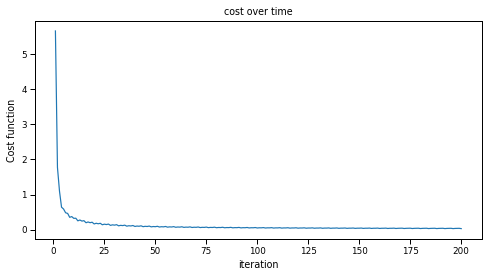

In [129]:
classes_list_2 = [0,1]
flex_Softmax_two_classes, two_class_costs_log, flex_Softmax_weights_dict_two = soft_max_iteration_flex(classes_list_2, x_train, y_train, [100,100,50], epochs= 150, batches = 4, xavier = 'yes')

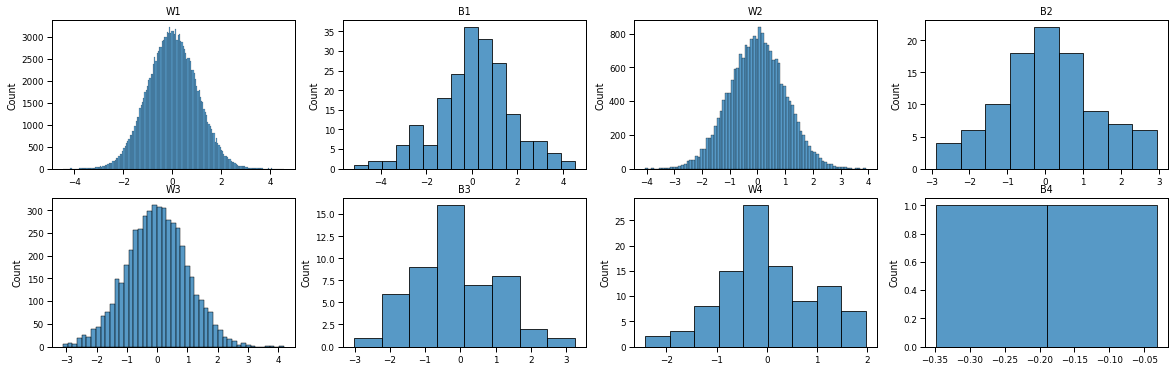

In [131]:
plot_weights(flex_Softmax_weights_dict_two)

[0, 1, 2]
(784, 18623)
Weights matrices
W1 (400, 784)
B1 (400, 1)
W2 (200, 400)
B2 (200, 1)
W3 (200, 200)
B3 (200, 1)
W4 (100, 200)
B4 (100, 1)
W5 (100, 100)
B5 (100, 1)
W6 (3, 100)
B6 (3, 1)
Training
Correct prediction score out of 1: 0.9648821349943618
Test!
Correct prediction score out of 1: 0.9478868763902129
/Users/jacoblourie/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


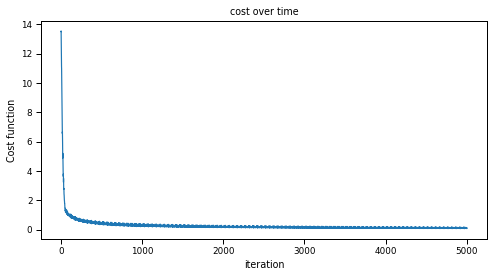

In [132]:
classes_list_3 = [0,1,2]
flex_Softmax_three_classes, three_class_costs_log, flex_Softmax_weights_dict_three = soft_max_iteration_flex(classes_list_3, x_train, y_train, [400,200,200,100,100], epochs= 5000, batches = 50, learning_rate = 0.005, xavier = 'yes')

In [ ]:
plot_weights(flex_Softmax_weights_dict_three)

[0, 1, 2, 3, 4]
(784, 30596)
Weights matrices
W1 (500, 784)
B1 (500, 1)
W2 (500, 500)
B2 (500, 1)
W3 (250, 500)
B3 (250, 1)
W4 (200, 250)
B4 (200, 1)
W5 (100, 200)
B5 (100, 1)
W6 (75, 100)
B6 (75, 1)
W7 (75, 75)
B7 (75, 1)
W8 (5, 75)
B8 (5, 1)
Training
Correct prediction score out of 1: 0.8781540070597463
Test!
Correct prediction score out of 1: 0.8384899785950574
/Users/jacoblourie/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


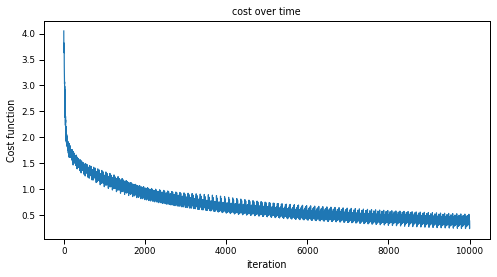

In [133]:
classes_list_five = [0,1,2,3,4]
flex_Softmax_five_classes, five_class_costs_log, flex_Softmax_weights_dict = soft_max_iteration_flex(classes_list_five, x_train, y_train, [500,500,250,200,100,75,75], epochs= 10000, batches = 100, learning_rate = 0.003,xavier='yes')

In [ ]:
pd.DataFrame(flex_Softmax_five_classes['A7'])

Let's also try a binary and a 3 class model

In [ ]:
pd.DataFrame(flex_softmax_three_classes['Z3'])

## Much better! let's try an even deeper network with 10 classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
(784, 60000)
Weights matrices
W1 (1000, 784)
B1 (1000, 1)
W2 (500, 1000)
B2 (500, 1)
W3 (500, 500)
B3 (500, 1)
W4 (200, 500)
B4 (200, 1)
W5 (200, 200)
B5 (200, 1)
W6 (100, 200)
B6 (100, 1)
W7 (100, 100)
B7 (100, 1)
W8 (10, 100)
B8 (10, 1)
Training
Correct prediction score out of 1: 0.7912166666666667
Test!
Correct prediction score out of 1: 0.699
/Users/jacoblourie/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


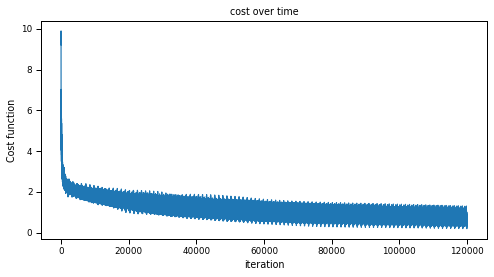

3227.301591157913


In [134]:
import time 
time_start = time.time()
classes_list = [0,1,2,3,4,5,6,7,8,9]
softmax_10_class_7_layer_FP_vals, softmax_10_class_7_layer_cost_log, flex_Softmax_weights_dict_ten = soft_max_iteration_flex(classes_list, x_train, y_train, [1000,500,500,200,200,100,100], learning_rate= 0.001, epochs= 120000, batches = 1200, xavier = 'yes')
print(time.time() - time_start)

softmax_10_class_7_layer_FP_vals, softmax_10_class_7_layer_cost_log, flex_Softmax_weights_dict_ten = soft_max_iteration_flex(classes_list, x_train, y_train, [1000,500,500,200,200,100,100], learning_rate= 0.05, epochs= 5000, batches = 200) best model so far

In [ ]:
plot_weights(flex_Softmax_weights_dict_ten)

Note ^^ There is an error with the predcitions formula above, re-ran below

## END OF DOCUMENT

Below here are just copy and paste from functions defined above, pasted here for ease of viewing when debugging

In [ ]:
#just putting this here for reference / remidner.
'''def gradient_descent_softmax(learning_rate, dict_of_weights, differentiat_dict):
    
    #we have dictionaries for the weights and the differentials, which we should be able to use quite easily here. They are also in order so we can kind of cheat... but let's not 
    for key, value in dict_of_weights.items():
        dict_of_weights[key] += -learning_rate * differentiat_dict[f'd{key}']
    
    
learning_rate = 0.1  #no idea if this is a good learning rate
gradient_descent(learning_rate, dict_of_weights, differentiat_dict)'''